In [1]:
!uv pip install scikit-image

Using Python 3.12.8 environment at: /home/taylor/code/ExtremeWeatherBench/.venv
Audited 1 package in 64ms


In [293]:
import xarray as xr
import numpy as np
import regionmask
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import dataclasses
from skimage.feature import peak_local_max
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from skimage import measure
from typing import Literal, Sequence, Optional
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy import spatial
from itertools import product
from collections import namedtuple

# Permutation Notes

As I'm writing out the MWE's, here's some notes on what I think might need to be accounted for:

1. Models that run every 3, 6, 12, 24 hours and how that translates to the max/min metrics (all valid times in a 12 hour frequency/6 hour resolution have 21 lead times, for example, compared to 6/6 runs with 41)
2. When to aggregate over lat/lons for area-averaged metrics
3. (TC) To find the local minima, the arrays need to be 2d; cannot roll up to (location, time) until after contours are found

In [3]:
def convert_longitude_to_360(longitude: float) -> float:
    """Convert a longitude from the range [-180, 180) to [0, 360)."""
    return np.mod(longitude, 360)

def lead_time_init_time_to_valid_time(forecast):
    """Convert init_time and lead_time to valid_time.
    
    Args:
        forecast: The forecast dataset.

    Returns:
        The forecast dataset with valid_time dimension.
    """
    if 'lead_time' not in forecast.dims or 'init_time' not in forecast.dims:
        raise ValueError("lead_time and init_time must be dimensions of the forecast dataset")
    
    lead_time_grid, init_time_grid = np.meshgrid(forecast.lead_time, forecast.init_time)
    valid_times = (
    init_time_grid.flatten()
    + pd.to_timedelta(lead_time_grid.flatten(), unit="h").to_numpy()
    )
    return valid_times

# Subset timesteps for forecast
def derive_indices_from_init_time_and_lead_time(
    dataset: xr.Dataset,
    start_date: datetime.datetime,
    end_date: datetime.datetime,
) -> np.ndarray:
    """Derive the indices of valid times in a dataset when the dataset has init_time and lead_time coordinates.

    Args:
        dataset: The dataset to derive the indices from.
        start_date: The start date to derive the indices from.
        end_date: The end date to derive the indices from.

    Returns:
        The indices of valid times in the dataset.

    Example:
        >>> import xarray as xr
        >>> import datetime
        >>> import pandas as pd
        >>> from extremeweatherbench.utils import (
        ...     derive_indices_from_init_time_and_lead_time,
        ... )
        >>> ds = xr.Dataset(
        ...     coords={
        ...         "init_time": pd.date_range("2020-01-01", "2020-01-03"),
        ...         "lead_time": [0, 24, 48],  # hours
        ...     }
        ... )
        >>> start = datetime.datetime(2020, 1, 1)
        >>> end = datetime.datetime(2020, 1, 4)
        >>> indices = derive_indices_from_init_time_and_lead_time(ds, start, end)
        >>> print(indices)
        array([0, 0, 1, 1, 2])
    """
    valid_times = lead_time_init_time_to_valid_time(dataset)
    valid_times_reshaped = valid_times.reshape(
        (
            dataset.init_time.shape[0],
            dataset.lead_time.shape[0],
        )
    )
    valid_time_mask = (valid_times_reshaped > pd.to_datetime(start_date)) & (
        valid_times_reshaped < pd.to_datetime(end_date)
    )
    valid_time_indices = np.asarray(valid_time_mask).nonzero()

    # The first index will subset init_time based on the first valid_time_reshaped line above
    # we don't need to subset lead_time but it might be useful in the future
    init_time_subset_indices = valid_time_indices[0]

    return init_time_subset_indices

def remove_ocean_gridpoints(dataset: xr.Dataset,drop: bool = True) -> xr.Dataset:
    """Subset a dataset to only include land gridpoints based on a land-sea mask.

    Args:
        dataset: The input xarray dataset.

    Returns:
        The dataset masked to only land gridpoints.
    """
    land = regionmask.defined_regions.natural_earth_v5_0_0.land_110
    land_sea_mask = land.mask(dataset.longitude, dataset.latitude)
    land_mask = land_sea_mask == 0
    # Subset the dataset to only include land gridpoints
    return dataset.where(land_mask, drop=drop)

In [221]:
#: ERA5 as a standin for forecast
ERA5_URI = "gs://gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3"
era5 = xr.open_zarr(
    ERA5_URI,
    chunks=None,
    storage_options=dict(token="anon"),
)

In [423]:
class CycloneDatasetBuilder:
    """
    A class to find cyclones in a dataset using the TempestExtremes criteria.
    <insert citation here>
    """
    min_tc_variables = ['mean_sea_level_pressure', 'geopotential_thickness']
    max_tc_variables = ['mean_sea_level_pressure', 'geopotential_thickness', '10m_u_component_of_wind', '10m_v_component_of_wind', 'u_component_of_wind', 'v_component_of_wind', 'temperature']
    
    def subset_variable(self, var_name: str, level_name: str = 'level', level_value: Optional[int | Sequence[int]] = None):
        if level_value is None:
            return self.ds[var_name]
        else:
            return self.ds[var_name].sel({level_name: level_value})
    
    def generate_geopotential_thickness(self, var_name: str = 'geopotential', level_name: str = 'level', top_level_value: int | Sequence[int] = [200,300,400], bottom_level_value: int = 500):
        geopotential_heights = self.subset_variable(var_name, level_name, top_level_value)
        geopotential_height_bottom = self.subset_variable(var_name, level_name, bottom_level_value)
        geopotential_thickness = (geopotential_heights - geopotential_height_bottom) / 9.80665
        geopotential_thickness.attrs = dict(description="Geopotential thickness of level and 500 hPa", units="m")
        return geopotential_thickness
    
    def subset_time(self, start_date: pd.Timestamp, end_date: pd.Timestamp):
        return self.ds.sel(time=slice(start_date, end_date))
    
    def subset_bounds(self, bounds: CoordinateBounds):
        return self.ds.sel(latitude=slice(bounds.max_lat, bounds.min_lat), longitude=slice(bounds.min_lon, bounds.max_lon))
    
    def subset_variables(self, tc_variable_amount: Literal['min','max']):
        """Subset the variables based on the variables argument.
        
        Using "min" will subset the minimum required variables - sea level pressure and geopotential thickness.
        Using "max" will subset the maximum required variables - sea level pressure, geopotential thickness, u and v surface winds, u and v 850 hPa winds, and air temperature at 400 hPa.
        Args:
            vars: The variable pattern to subset.

        Returns:
            The subsetted variables.
        """
        if tc_variable_amount == 'min':
            output = xr.Dataset({'mean_sea_level_pressure': self.subset_variable('mean_sea_level_pressure'),
                             'geopotential_thickness': self.generate_geopotential_thickness(top_level_value=300, bottom_level_value=500)},
                            )
        elif tc_variable_amount == 'max':
            output = xr.Dataset({'mean_sea_level_pressure': self.subset_variable('mean_sea_level_pressure'),
                             'geopotential_thickness': self.generate_geopotential_thickness(top_level_value=300, bottom_level_value=500),
                             '10m_u_component_of_wind': self.subset_variable('10m_u_component_of_wind'),
                             '10m_v_component_of_wind': self.subset_variable('10m_v_component_of_wind'),
                             'u_component_of_wind': self.subset_variable('u_component_of_wind', level_value=850),
                             'v_component_of_wind': self.subset_variable('v_component_of_wind', level_value=850),
                             'temperature': self.subset_variable('temperature', level_value=[300,400,500])},
                            )
        return output

    def build_dataset(self, ds: xr.Dataset, start_date: pd.Timestamp, end_date: pd.Timestamp, bounds: CoordinateBounds, hour_subset: list[int] = [0,6,12,18], tc_variable_amount: Literal['min','max'] = 'min'):
        """
        Build a dataset of the cyclone data.
        """
        self.ds = ds.sel(time=ds.time.dt.hour.isin(hour_subset))
        self.ds = self.subset_time(start_date, end_date)
        self.ds = self.subset_bounds(bounds)
        # subset variables in line with TempestExtremes requirements
        te_dataset = self.subset_variables(tc_variable_amount)
        return te_dataset

Location = namedtuple('Location', ['latitude', 'longitude'])

@dataclasses.dataclass
class TC:
    id: int
    valid_time: pd.Timestamp
    coordinate: Location


@dataclasses.dataclass
class TCTrack:
    id: int
    track: list[TC]

    def plot(self, ax: plt.Axes, *args,**kwargs):
        """
        Plot the TCTrack line on the given axes.
        """
        # Extract lat/lon coordinates from track
        lats = [tc.coordinate.latitude for tc in self.track]
        lons = [tc.coordinate.longitude for tc in self.track]
        
        # Plot the track line
        line = ax.plot(lons, lats, *args, **kwargs)
        return line


def find_furthest_contour_from_point(contour: np.ndarray, point: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    """Find the two points in a contour that are furthest apart.
    From https://stackoverflow.com/questions/50468643/finding-two-most-far-away-points-in-plot-with-many-points-in-python
    """

    # Calculate distances from point to all points in contour
    distances = spatial.distance.cdist([point], contour)[0]
    # Find index of point with maximum distance
    furthest_idx = np.argmax(distances)
    
    # Get the furthest point
    i = furthest_idx
    return contour[i]

def convert_from_cartesian_to_latlon(input_point: np.ndarray, ds_mapping: xr.Dataset) -> tuple[float, float]:
    """Convert a point from the cartesian coordinate system to the lat/lon coordinate system.

    Args:
        input_point: The point to convert, represented as a tuple (y, x) in the cartesian coordinate system.
        ds_mapping: The dataset containing the latitude and longitude coordinates.

    Returns:
        The point in the lat/lon coordinate system, represented as a tuple (latitude, longitude) in degrees.
    """
    return (
        ds_mapping.isel(
            latitude=int(input_point[0]), 
            longitude=int(input_point[1])
            ).latitude.values, 
       
        ds_mapping.isel(
            latitude=int(input_point[0]), 
            longitude=int(input_point[1])
            ).longitude.values
    )

def calculate_degree_distance(point1: np.ndarray, point2: np.ndarray) -> float:
    """Calculate the great-circle distance between two points on the Earth's surface.
    
    Args:
        point1: The first point, represented as a tuple (latitude, longitude) in degrees.
        point2: The second point, represented as a tuple (latitude, longitude) in degrees.

    Returns:
        The great-circle distance between the two points in kilometers.
    """
    # Convert degrees to radians
    # Convert degrees to radians
    point1_lat, point1_lon = point1
    point2_lat, point2_lon = point2
    dist = np.sqrt((point1_lat - point2_lat)**2 + (point1_lon - point2_lon)**2)
    return dist


def find_contours_from_point_specified_field(field: xr.DataArray, point: tuple[float, float], level: float) -> Sequence[tuple[float, float]]:
    field_at_point = field - field.isel(latitude=point[0], longitude=point[1])
    contours = measure.find_contours(field_at_point.values, level=level, positive_orientation='high')
    return contours

def find_valid_contour_from_point(contour: Sequence[tuple[float, float]], point: tuple[float, float], ds_mapping: xr.Dataset) -> tuple[float, float]:
    gc_distance_point = find_furthest_contour_from_point(contour, point)
    gc_distance_point_latlon = convert_from_cartesian_to_latlon(gc_distance_point, ds_mapping)
    point_latlon = convert_from_cartesian_to_latlon(point, ds_mapping)
    gc_distance_contour_distance = calculate_degree_distance(gc_distance_point_latlon, point_latlon)
    return gc_distance_contour_distance

def find_valid_candidates(
        slp_contours: Sequence[Sequence[tuple[float, float]]], 
        dz_contours: Sequence[Sequence[tuple[float, float]]],
        point: tuple[float, float],
        ds_mapping: xr.Dataset,
        max_gc_distance_slp_contour: float = 5.5,
        max_gc_distance_dz_contour: float = 6.5,
        ) -> dict[pd.Timestamp, tuple[float, float]]:
    for slp_contour, dz_contour in product(slp_contours, dz_contours):
        if (
            # Only check closed contours
            all(np.isclose(slp_contour[-1], slp_contour[0])) and  
            all(np.isclose(dz_contour[-1], dz_contour[0])) and
            # Check if point is inside both contour types
            measure.points_in_poly([[point[0], point[1]]], slp_contour)[0] and
            measure.points_in_poly([[point[0], point[1]]], dz_contour)[0] and

            # Check if the contour is within the max great circle distance
            find_valid_contour_from_point(slp_contour, point, ds_mapping) < max_gc_distance_slp_contour and
            find_valid_contour_from_point(dz_contour, point, ds_mapping) < max_gc_distance_dz_contour
        ):
            valid_candidate = Location(latitude=convert_from_cartesian_to_latlon(point, ds_mapping)[0], longitude=convert_from_cartesian_to_latlon(point, ds_mapping)[1])
            return valid_candidate
    return None

def check_orography(tc_track: TCTrack, orography: xr.DataArray) -> bool:
    """Check if the TC tracks have at least 8 steps below 150m."""
    for i, step in enumerate(tc_track.track):
        if i < 8 and orography.sel(latitude=step.coordinate.latitude, longitude=step.coordinate.longitude, method='nearest').min() > 150:
            return False
    return True


def create_tctracks(tcs: list[TC], orography: xr.DataArray) -> list[TCTrack]:
    """
    Create a TCTrack from a list of TCs.
    
    Groups TCs into tracks if they are:
    1. At unique timesteps
    2. Within 8 great circle degrees of the previous timestep
    3. Within 54 hours of the previous timestep
    
    Returns a list of TCTrack objects.
    """
    # Sort TCs by time
    tcs = sorted(tcs, key=lambda x: x.valid_time)
    
    tracks = []
    used_tc_ids = set()  # Track TCs by their IDs instead of objects
    track_id = 0
    for tc in tcs:
        if tc.id in used_tc_ids:
            continue
            
        # Start a new track with this TC
        current_track = [tc]
        used_tc_ids.add(tc.id)
        
        # Find subsequent TCs that could be part of this track
        last_tc = tc
        for next_tc in tcs:
            if next_tc.id in used_tc_ids:
                continue
                
            # Check if within 54 hours
            time_diff = (next_tc.valid_time - last_tc.valid_time).total_seconds() / 3600
            if time_diff > 54:
                continue
                
            # Check if within 8 degrees
            distance = calculate_degree_distance(
                (last_tc.coordinate.latitude, 
                last_tc.coordinate.longitude),
                (next_tc.coordinate.latitude,
                next_tc.coordinate.longitude)
            )
            
            if distance <= 8:
                current_track.append(next_tc)
                used_tc_ids.add(next_tc.id)
                last_tc = next_tc
        
        # Create track if it has points
        if len(current_track) > 1:
            tracks.append(TCTrack(id=track_id, track=current_track))
            track_id += 1
    tracks = [track for track in tracks if check_orography(track, orography)]
    return tracks

@dataclasses.dataclass
class CoordinateBounds:
    min_lat: float
    max_lat: float
    min_lon: float
    max_lon: float

    
#event metadata
start_date = pd.Timestamp('2024-09-20 00:00')
end_date = pd.Timestamp('2024-09-29 00:00')
basin = CoordinateBounds(min_lat=0.25, max_lat=52, min_lon=260, max_lon=359)
# Initialize the CycloneDatasetBuilder object.
cyclone_dataset_builder = CycloneDatasetBuilder()

# Build the dataset of the cyclone data.
cyclone_dataset = cyclone_dataset_builder.build_dataset(era5, start_date, end_date, basin, tc_variable_amount='min')

In [424]:
def create_tctracks_from_dataset(
        cyclone_dataset: xr.Dataset,
        slp_contour_magnitude = 200,
        dz_contour_magnitude = -6,
        min_distance = 12
        ):
    # Find the SLP minima
    slp = cyclone_dataset['mean_sea_level_pressure']
    # Find the DZ maxima
    dz = cyclone_dataset['geopotential_thickness']
    valid_candidates = []
    # Initialize the id number to increment for each new TC
    id_number = 0
    for time in slp.time:
        slp_time = slp.sel(time=time)
        dz_time = dz.sel(time=time)
        candidate_slp_points = peak_local_max(
            -(slp_time.values),
            min_distance=min_distance,
            # exclude_border=0 required as points <= min_distance from border are not included
            exclude_border=0
        )

        for point in candidate_slp_points:
            slp_contours = find_contours_from_point_specified_field(slp_time, point, slp_contour_magnitude)
            dz_contours = find_contours_from_point_specified_field(dz_time, point, dz_contour_magnitude)
            candidate = find_valid_candidates(slp_contours, dz_contours, point, slp_time)
            
            if candidate is not None:
                tc = TC(id=id_number, valid_time=pd.to_datetime(time.values), coordinate=candidate)
                valid_candidates.append(tc)
                # Increment the id number for the next individual TC point
                id_number += 1
        
    tctracks = create_tctracks(valid_candidates, era5.isel(time=1000000)['geopotential_at_surface']/9.80665)        
    return tctracks            


tctracks = create_tctracks_from_dataset(cyclone_dataset)

In [425]:
tctracks

[TCTrack(id=0, track=[TC(id=2, valid_time=Timestamp('2024-09-22 18:00:00'), coordinate=Location(latitude=array(13.75, dtype=float32), longitude=array(261.25, dtype=float32))), TC(id=3, valid_time=Timestamp('2024-09-23 18:00:00'), coordinate=Location(latitude=array(15.5, dtype=float32), longitude=array(261.25, dtype=float32)))]),
 TCTrack(id=1, track=[TC(id=4, valid_time=Timestamp('2024-09-24 00:00:00'), coordinate=Location(latitude=array(18.75, dtype=float32), longitude=array(278.75, dtype=float32))), TC(id=5, valid_time=Timestamp('2024-09-24 06:00:00'), coordinate=Location(latitude=array(19.5, dtype=float32), longitude=array(276.75, dtype=float32))), TC(id=6, valid_time=Timestamp('2024-09-24 12:00:00'), coordinate=Location(latitude=array(19.25, dtype=float32), longitude=array(276., dtype=float32))), TC(id=7, valid_time=Timestamp('2024-09-24 18:00:00'), coordinate=Location(latitude=array(19.5, dtype=float32), longitude=array(275.75, dtype=float32))), TC(id=8, valid_time=Timestamp('2024

In [345]:
aifs_ds = xr.open_dataset('/home/taylor/data/aifs.era5.20240922T00Z.nc',chunks='auto')
cyclone_dataset_builder = CycloneDatasetBuilder()
aifs_cyclone_dataset = cyclone_dataset_builder.build_dataset(aifs_ds, start_date, end_date, basin, tc_variable_amount='min')
aifs_tctracks = create_tctracks_from_dataset(aifs_cyclone_dataset)

In [ ]:
# Download the IBTrACS data if needed
#  !wget https://www.ncei.noaa.gov/data/international-best-track-archive-for-climate-stewardship-ibtracs/v04r01/access/csv/ibtracs.ALL.list.v04r01.csv -O /home/taylor/data/ibtracs.csv

--2025-06-16 18:28:30--  https://www.ncei.noaa.gov/data/international-best-track-archive-for-climate-stewardship-ibtracs/v04r01/access/csv/ibtracs.ALL.list.v04r01.csv
Resolving www.ncei.noaa.gov (www.ncei.noaa.gov)... 205.167.25.172, 205.167.25.178, 205.167.25.177, ...
Connecting to www.ncei.noaa.gov (www.ncei.noaa.gov)|205.167.25.172|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 327311730 (312M) [text/csv]
Saving to: ‘/home/taylor/data/ibtracs.csv’

/home/taylor/data/i 100%[===================>] 312.15M  18.8MB/s    in 13s     

2025-06-16 18:28:44 (24.0 MB/s) - ‘/home/taylor/data/ibtracs.csv’ saved [327311730/327311730]



In [226]:
tburg_tracks = pd.read_csv('gs://brightband-tc/tburg/AL092024/2024092200/tracks.csv')
tburg_tracks['lon'] = convert_longitude_to_360(tburg_tracks['lon'])

In [119]:
!uv pip install tropycal
import tropycal.tracks as tracks

ibtracs = tracks.TrackDataset(basin='all',source='ibtracs',ibtracs_url='/home/taylor/data/ibtracs.csv')
storm = ibtracs.get_storm(('helene',2024))
storm_df = storm.to_dataframe()
storm_ds = storm.to_xarray()
storm_ds = storm_ds.sel(time=storm_ds.time.dt.hour.isin([0,6,12,18]))


Using Python 3.12.8 environment at: /home/taylor/code/ExtremeWeatherBench/.venv
Audited 1 package in 5ms
--> Starting to read in ibtracs data
--> Completed reading in ibtracs data (17.32 seconds)


In [249]:
pd.to_datetime('2024-09-22 00:00:00') + pd.Timedelta(hours=192)

Timestamp('2024-09-30 00:00:00')

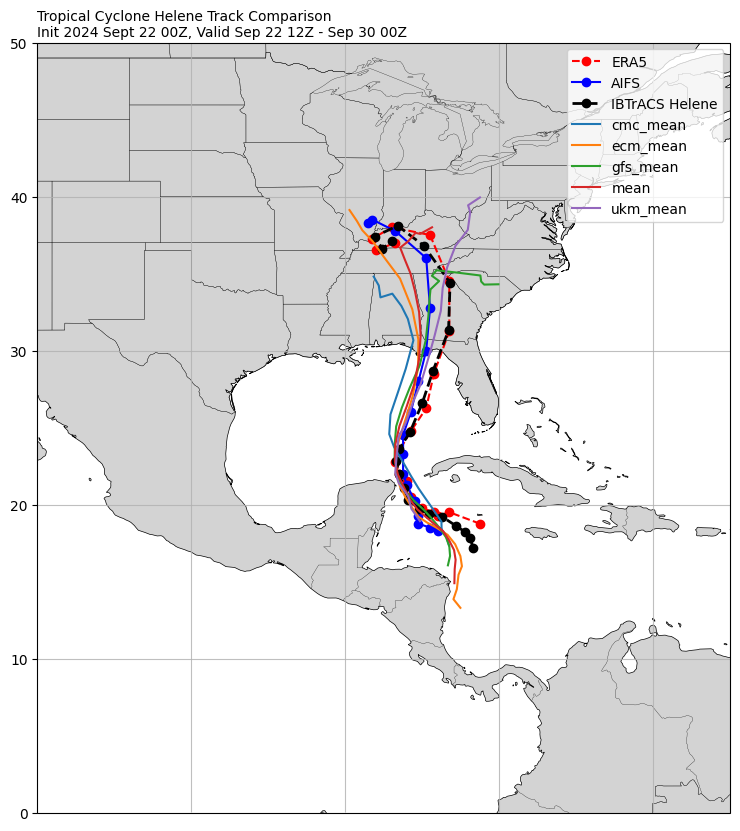

In [438]:
fig = plt.figure(figsize=(15, 10))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.BORDERS,linewidth=0.2)
ax.gridlines(alpha=0.8)
ax.add_feature(cfeature.STATES,linewidth=0.2)

ax.add_feature(cfeature.LAND,facecolor='lightgray',edgecolor='k',linewidth=0.5)
ax.set_extent([250,295, 0, 50], crs=ccrs.PlateCarree())

# Plot first point of ERA5 track with larger marker and annotation

tctracks[1].plot(ax=ax,transform=ccrs.PlateCarree(),label='ERA5',color='r',marker='o',linestyle='--')
aifs_tctracks[1].plot(ax=ax,transform=ccrs.PlateCarree(),label='AIFS',color='b',marker='o')
# Plot track line connecting points
ax.plot(storm_ds.lon, storm_ds.lat, 'k--', transform=ccrs.PlateCarree(), linewidth=2, marker='o',label='IBTrACS Helene')
for name, group in tburg_tracks.groupby('model'):
    if 'mean' in name:
        group.plot(x='lon',y='lat',ax=ax,transform=ccrs.PlateCarree(),label=name)
ax.legend()
ax.set_title(('Tropical Cyclone Helene Track Comparison\n'
             r'Init 2024 Sept 22 00Z, Valid Sep 22 12Z - Sep 30 00Z'),
             wrap=True,
             loc='left',
             fontsize=10)
plt.show()



# Test on Graphcast GFS Realtime

In [310]:
!uv pip install virtualizarr
from virtualizarr import open_virtual_dataset

virtual_dataset = open_virtual_dataset('s3://noaa-oar-mlwp-data/GRAP_v100_GFS/2025/0616/GRAP_v100_GFS_2025061612_f000_f240_06.nc',
                                       decode_times=True,
                                       loadable_variables=['time','latitude','longitude','level'],
                                       reader_options={'storage_options': {'anon': True}})
virtual_dataset.virtualize.to_kerchunk('graphcast_gfs.parq',format='parquet')



Using Python 3.12.8 environment at: /home/taylor/code/ExtremeWeatherBench/.venv
Audited 1 package in 4ms


In [366]:
storage_options = {
    "remote_protocol": 's3',
    "remote_options": {"anon": True},
}  # options passed to fsspec
open_dataset_options: dict = {"chunks": {}}  # opens passed to xarray

grap_ds = xr.open_dataset(
    'graphcast_gfs.parq',
    engine="kerchunk",
    storage_options=storage_options,
    open_dataset_options=open_dataset_options,
)
grap_ds = grap_ds.compute()
grap_ds = grap_ds.rename({'msl': 'mean_sea_level_pressure', 
                              't': 'temperature', 
                              't2': '2m_temperature',
                              'u': 'u_component_of_wind', 
                              'v': 'v_component_of_wind', 
                              'z': 'geopotential',
                              })

In [426]:
cyclone_dataset_builder = CycloneDatasetBuilder()
start_date = pd.Timestamp('2025-06-16 12:00:00')
end_date = pd.Timestamp('2025-06-16 12:00:00') + pd.Timedelta(hours=240)
grap_cyclone_dataset = cyclone_dataset_builder.build_dataset(grap_ds, start_date, end_date, basin, tc_variable_amount='min')
grap_tctracks = create_tctracks_from_dataset(grap_cyclone_dataset)

In [439]:
grap_cyclone_dataset

<xarray.Dataset> Size: 27MB
Dimensions:                  (latitude: 208, longitude: 397, time: 41)
Coordinates:
  * latitude                 (latitude) float32 832B 52.0 51.75 ... 0.5 0.25
  * longitude                (longitude) float32 2kB 260.0 260.2 ... 358.8 359.0
  * time                     (time) datetime64[ns] 328B 2025-06-16T12:00:00 ....
Data variables:
    mean_sea_level_pressure  (time, latitude, longitude) float32 14MB dask.array<chunksize=(1, 208, 397), meta=np.ndarray>
    geopotential_thickness   (time, latitude, longitude) float32 14MB dask.array<chunksize=(1, 208, 397), meta=np.ndarray>

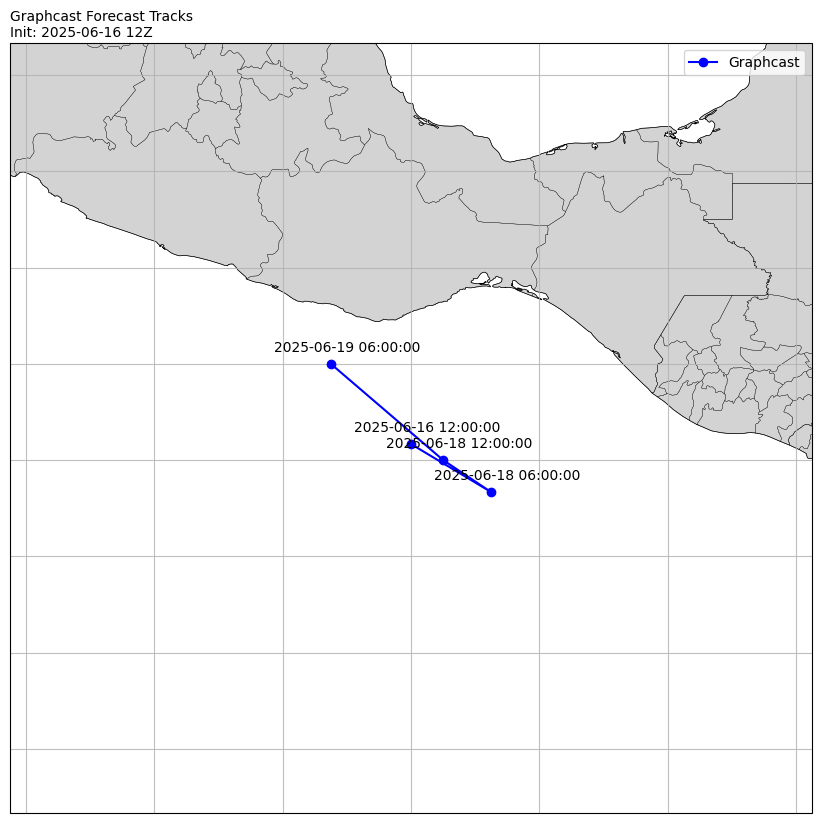

In [437]:
fig = plt.figure(figsize=(15, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
# Add map features
ax.add_feature(cfeature.BORDERS,linewidth=0.2)
ax.gridlines(alpha=0.8)
ax.add_feature(cfeature.STATES,linewidth=0.2)

ax.add_feature(cfeature.LAND,facecolor='lightgray',edgecolor='k',linewidth=0.5)

lons = [n.coordinate.longitude for grap_tctrack in grap_tctracks for n in grap_tctrack.track]
lats = [n.coordinate.latitude for grap_tctrack in grap_tctracks for n in grap_tctrack.track]
ax.set_extent([np.min(lons)-5,np.max(lons)+5, np.min(lats)-5, np.max(lats)+5], crs=ccrs.PlateCarree())

# Plot first point of ERA5 track with larger marker and annotation
[n.plot(ax=ax,transform=ccrs.PlateCarree(),label='Graphcast',color='b',marker='o') for n in grap_tctracks]
[ax.annotate(n.valid_time.strftime('%Y-%m-%d %H:%M:%S'), xy=(n.coordinate.longitude+1, n.coordinate.latitude+1), xytext=(n.coordinate.longitude+0.25, n.coordinate.latitude+0.25), fontsize=10, ha='center', va='center') for n in grap_tctracks[0].track]
ax.legend()
ax.set_title('Graphcast Forecast Tracks\nInit: 2025-06-16 12Z', wrap=True, loc='left', fontsize=10)
plt.show()



# Positive TC Formation Detection
This metric will look back on model outputs up to 240 hours before TC formation and determines if a TC signature is identified within 8 (can be changed) great circle degrees of first IBTrACS position, outputting the resulting lead time which the model produces a spatially colocated TC

# Spatial Landfall Error
Determines the location error of landfall as a function of lead time

# Temporal Landfall Error
Determines the forward motion error of landfall as a function of lead time

# MAE Landfall Intensity
Due to resolution error it is expected to have a weak bias in the SLP field. What is the MAE at landfall for the predicted TC?